In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable
import os
from metal.mmtl.cxr.analysis.notebooks.cxr_analysis import load_log_json, load_results_from_log
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads

In [3]:
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_naive_10_22_22'
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_hps_10_19_59'
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_22_19_24'
model_log = '/lfs/1/jdunnmon/repos/metal/logs/2019_05_02/sps_drain_slice_neg_test_fine_tune_all_pneumo_10_16_56'
model = torch.load(os.path.join(model_log,'model.pkl'))

In [4]:
#os.environ['CXRDATA']='/data/datasets/mmtl/cxr/'
#os.environ['CXR8IMAGES']='/data/datasets/nih/images/images'
os.environ['CXRDATA']='/dfs/scratch0/jdunnmon/data/mmtl/cxr'
os.environ['CXR8IMAGES']='/lfs/1/jdunnmon/data/nih/images/images'
log_jsons = load_results_from_log(model_log)
log_jsons['task_config']['subsample'] = -1
log_jsons['task_config']['eval_finding'] = 'ALL'
task_names=['CXR8-DRAIN_ALL']
tasks, payloads = create_tasks_and_payloads(task_names, **log_jsons['task_config'], batch_size=32)

Could not find kwarg "finding" in destination dict.


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Loading CXR8-DRAIN Dataset
Using train finding ALL
Using resolution 224...


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Using dataset seed: 1701
Using eval finding ALL
Using resolution 224...
Using dataset seed: 1701
Using eval finding ALL
Using resolution 224...
Using dataset seed: 1701
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind to payload CXR8-DRAIN_train.
Added label_set with 62608/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred to payload CXR8-DRAIN_train.
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:BASE:ind to payload CXR8-DRAIN_train.
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:BASE:pred to payload CXR8-DRAIN_train.
Added label_set with 11259/11259 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind to payload CXR8-DRAIN_valid.
Added label_set with 10923/11259 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred to payload CXR8-DRAIN_valid.
Added label_set with 11259/11259 labels for task CXR8-DRAIN_PNEUMO

In [21]:
predict_tasks = {'CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred':'NO CHEST DRAINS',
              'CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind':'NO CHEST DRAINS IND',
              'CXR8-DRAIN_PNEUMOTHORAX':'ALL'}
model.cuda()
Ys, Ys_probs, Ys_preds, Ys_meta = model.predict_with_gold(payloads[1],
    target_tasks=predict_tasks.keys(),
    target_labels=predict_tasks.keys(),
    return_preds=True,
    return_meta=['uid'])

In [22]:
eval_tasks = {'CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred':'NO CHEST DRAINS',
              'CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind':'NO CHEST DRAINS IND',
              'CXR8-DRAIN_PNEUMOTHORAX':'ALL'}

from metal.metrics import roc_auc_score, prc_auc_score
fpr = {}
tpr = {}
thresh = {}
scores = {}
prc = {}
rec = {}
for score_task in eval_tasks.keys():
    scorer = model.task_map[score_task].scorer
    scorer.standard_metrics = ['f1','roc-auc','prc-auc','accuracy','precision','recall']
    print(f"Scoring {score_task}")
    scores[score_task] = scorer.score(
                    Ys[score_task],
                    Ys_probs[score_task],
                    Ys_preds[score_task],
                    #target_metrics=target_metrics[label_name],
                )
    print(scores[score_task])
    fpr[score_task], tpr[score_task], thresh[score_task] = roc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_roc=True)
    prc[score_task], rec[score_task], _ = prc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_prc=True)

Scoring CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred
{'f1': 0.11019283746556476, 'roc-auc': 0.7748994938798952, 'prc-auc': 0.5313466368395185, 'accuracy': 0.97042936922091, 'precision': 0.12903225806451613, 'recall': 0.09615384615384616}
Scoring CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind
{'f1': 0.9013338662137184, 'roc-auc': 0.8998928647720189, 'prc-auc': 0.5988238997836812, 'accuracy': 0.8245847766231459, 'precision': 0.9919727292720475, 'recall': 0.8258720131831915}
Scoring CXR8-DRAIN_PNEUMOTHORAX
{'f1': 0.42162162162162165, 'roc-auc': 0.8843707539595399, 'prc-auc': 0.6980156885114633, 'accuracy': 0.9524824584776623, 'precision': 0.5118110236220472, 'recall': 0.3584558823529412}


In [206]:
import numpy as np

outside_slice_task = 'WITH CHEST DRAINS'
eval_tasks['outside_slice_task'] = outside_slice_task

# Get inds inside drain slice
drain_slice_inds = np.array([a[0]==1 for a in Ys['CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind']])
# Get inds with pneumos
pneumo_inds = np.array([a[0]==1 for a in Ys['CXR8-DRAIN_PNEUMOTHORAX']])
# Get pneumos outside drain slice + negatives
outside_drain_slice_inds = np.array([pneumo_inds[i]*~drain_slice_inds[i] or ~pneumo_inds[i] for i in range(len(Ys['CXR8-DRAIN_PNEUMOTHORAX']))])
# Add to Ys, Y_preds, etc
Ys['outside_slice_task'] = np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_inds]
Ys_probs['outside_slice_task'] = np.array(Ys_probs['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_inds]
Ys_preds['outside_slice_task'] = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_inds]


In [26]:
score_task = 'outside_slice_task'
scores[score_task] = {}
fpr[score_task], tpr[score_task], _ = roc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_roc=True)
prc[score_task], rec[score_task], _ = prc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_prc=True)
scores[score_task]['roc-auc'] = roc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_roc=False)
scores[score_task]['prc-auc'] = prc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_prc=False)



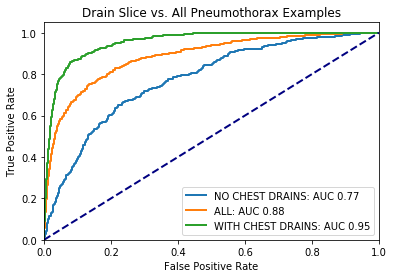

In [41]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
for score_task in eval_tasks:
    if ":ind" not in score_task:
        plt.plot(fpr[score_task], tpr[score_task],
             lw=lw, label=f'{eval_tasks[score_task]}: AUC %0.2f' % scores[score_task]['roc-auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Drain Slice vs. All Pneumothorax Examples')
plt.legend(loc="lower right")
plt.savefig('../figures/05_04_2019/roc-slice-val.png')
plt.show()

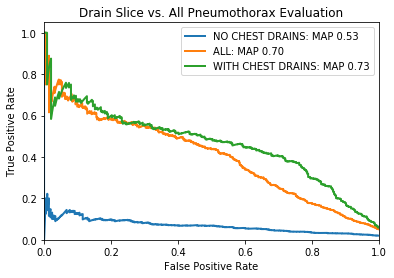

In [39]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
for score_task in eval_tasks:
    if ":ind" not in score_task:
        plt.plot(rec[score_task], prc[score_task],
                 lw=lw, label=f'{eval_tasks[score_task]}: MAP %0.2f' % scores[score_task]['prc-auc'])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Drain Slice vs. All Pneumothorax Evaluation')
plt.legend(loc="upper right")
plt.savefig('../figures/05_04_2019/prc-slice-val.png')
plt.show()

## SANDBOX

In [43]:
outside_drain_slice_pneumos = np.array([pneumo_inds[i]*~drain_slice_inds[i] for i in range(len(Ys['CXR8-DRAIN_PNEUMOTHORAX']))])
inside_drain_slice_pneumos = np.array([pneumo_inds[i]*drain_slice_inds[i] for i in range(len(Ys['CXR8-DRAIN_PNEUMOTHORAX']))])

In [59]:
Ys['no_drain_pneumos'] = np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX'])[inside_drain_slice_pneumos]
Ys_probs['no_drain_pneumos'] = np.array(Ys_probs['CXR8-DRAIN_PNEUMOTHORAX'])[inside_drain_slice_pneumos]
Ys_preds['no_drain_pneumos'] = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX'])[inside_drain_slice_pneumos]

Ys['drain_pneumos'] = np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_pneumos]
Ys_probs['drain_pneumos'] = np.array(Ys_probs['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_pneumos]
Ys_preds['drain_pneumos'] = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX'])[outside_drain_slice_pneumos]

In [62]:
import sklearn.metrics as skm
import pprint
print(skm.classification_report(Ys['no_drain_pneumos'],Ys_preds['no_drain_pneumos']))

              precision    recall  f1-score   support

           1       1.00      0.12      0.21       208
           2       0.00      0.00      0.00         0

   micro avg       0.12      0.12      0.12       208
   macro avg       0.50      0.06      0.10       208
weighted avg       1.00      0.12      0.21       208



/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [64]:
print(skm.classification_report(Ys['drain_pneumos'],Ys_preds['drain_pneumos']))

              precision    recall  f1-score   support

           1       1.00      0.51      0.67       336
           2       0.00      0.00      0.00         0

   micro avg       0.51      0.51      0.51       336
   macro avg       0.50      0.25      0.34       336
weighted avg       1.00      0.51      0.67       336



/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [65]:
print(skm.classification_report(Ys['outside_slice_task'],Ys_preds['outside_slice_task']))

              precision    recall  f1-score   support

           1       0.48      0.51      0.49       336
           2       0.98      0.98      0.98     10715

   micro avg       0.97      0.97      0.97     11051
   macro avg       0.73      0.75      0.74     11051
weighted avg       0.97      0.97      0.97     11051



In [ ]:
Say the slice indicator is only 70% accurate, then in 30% of predictions you get the main head and do no worse… and in fact, you really only care about those cases in which the slice *overrules* the head. You could test your hypthoses by feeding some dev (not seen in train) through the indicator and seeing if it picks out those should be overruled. You can select these by hand. 

If you’re overfitting on train, that’s good. It means that you have capacity to fit the model.

There is a decision tree, get numbers for each?
Should be overruled/Not
Indicator fires or not
Prediction correct or not.
 
If you are getting an example that should be overruled, but the prediction head is not doing it—then you have a training issue in what you’re feeding to that head?

hope that helps!

Chris

In [253]:
np.sum(correctly_indicated_for_overrule)

232

In [254]:
# Getting predictions and ground truth
slice_members = drain_slice_inds # or inside_drain_slice_pneumos, drain_slice_inds
main_head_predictions = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX'])
slice_head_indicators = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind'])
slice_head_predictions = np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred'])
ground_truth = np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX']).squeeze()

# Number of examples
number_in_slice = np.sum(slice_members)
positives_in_slice = (np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX']).squeeze()==1) & slice_members
negatives_in_slice = (np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX']).squeeze()==2) & slice_members
positives_out_slice = (np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX']).squeeze()==1) & ~slice_members
negatives_out_slice = (np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX']).squeeze()==2) & ~slice_members


positives_indicated_in_slice = slice_head_indicators & positives_in_slice
negatives_indicated_in_slice = slice_head_indicators & negatives_in_slice
positives_indicated_out_slice = ~slice_head_indicators & positives_out_slice
negatives_indicated_out_slice = ~slice_head_indicators & negatives_out_slice


# Want to overrule: (a) in the slice positives and (b) predicts incorrectly
need_to_overrule = ~np.equal(main_head_predictions[slice_members], 
                         ground_truth[slice_members])
positives_to_overrule = ground_truth[slice_members][need_to_overrule]==1
negatives_to_overrule = ground_truth[slice_members][need_to_overrule]==2

# Does slice fire on these heads?
correctly_indicated_for_overrule = slice_head_indicators[slice_members]==1 & need_to_overrule
positives_correctly_indicated_for_overrule = correctly_indicated_for_overrule & (ground_truth[slice_members]==1)
negatives_correctly_indicated_for_overrule = correctly_indicated_for_overrule & (ground_truth[slice_members]==2)

incorrectly_indicated_for_overrule = slice_head_indicators[slice_members]==1 & ~need_to_overrule

correctly_not_indicated_for_overrule = slice_head_indicators[slice_members]==2 & ~need_to_overrule
incorrectly_not_indicated_for_overrule = slice_head_indicators[slice_members]==2 & need_to_overrule

# Do we get the right answer?
correctly_overruled = (slice_ground_truth[slice_members] & slice_head_predictions[slice_members]) & correctly_indicated_for_overrule
incorrectly_not_overruled = (slice_ground_truth[slice_members] & slice_head_predictions[slice_members]) & incorrectly_not_indicated_for_overrule

correctly_not_overruled = (slice_ground_truth[slice_members] & slice_head_predictions[slice_members]) & correctly_not_indicated_for_overrule
incorrectly_overruled = (slice_ground_truth[slice_members] & slice_head_predictions[slice_members]) & incorrectly_indicated_for_overrule

print(f"SIZE OF SLICE:")
print(f"Slice contains {number_in_slice} of {len(slice_inds)} examples \n")

print(f"OVERALL:")
print(f"Indicator fires on {100*np.round(np.sum(slice_head_indicators==1)/number_in_slice,2)} percent of examples in the slice ({np.sum(slice_head_indicators==1)}/{number_in_slice}) \n")
print(f"On in-slice positive examples, the indicator correctly identifies {100*np.round(np.sum(positives_indicated_in_slice)/np.sum(positives_in_slice),2)} percent ({np.sum(positives_indicated_in_slice)}/{np.sum(positives_in_slice)})")
print(f"On in-slice negative examples, the indicator correctly identifies {100*np.round(np.sum(negatives_indicated_in_slice)/np.sum(negatives_in_slice),2)} percent ({np.sum(negatives_indicated_in_slice)}/{np.sum(negatives_in_slice)}) \n")

print(f"On out-of-slice positive examples, the indicator correctly identifies {100*np.round(np.sum(positives_indicated_out_slice)/np.sum(positives_out_slice),2)} percent ({np.sum(positives_indicated_out_slice)}/{np.sum(positives_out_slice)})")
print(f"On out-of-slice negative examples, the indicator correctly identifies {100*np.round(np.sum(negatives_indicated_out_slice)/np.sum(negatives_out_slice),2)} percent ({np.sum(negatives_indicated_out_slice)}/{np.sum(negatives_out_slice)}) \n")

print("OVERRULE:")
print(f"Need to overrule {100*np.round(np.sum(need_to_overrule)/number_in_slice,2)} percent of examples in slice head ({np.sum(need_to_overrule)}/{number_in_slice})")
print(f"Of these, {100*np.round(np.sum(positives_to_overrule)/np.sum(need_to_overrule),2)} percent are positive ({np.sum(positives_to_overrule)}/{np.sum(need_to_overrule)})\n")

print(f"OF THOSE IN THE SLICE NEEDING TO BE OVERRULED:")
print(f"Indicator fires on {100*np.round(np.sum(correctly_indicated_for_overrule)/np.sum(need_to_overrule),2)} percent ({np.sum(correctly_indicated_for_overrule)}/{np.sum(need_to_overrule)})")
print(f"Of these, {np.sum(positives_correctly_indicated_for_overrule)} are positive and  {np.sum(negatives_correctly_indicated_for_overrule)} are negative\n")


print("OF THOSE IN THE SLICE, BUT NOT NEEDING TO BE OVERRULED:")
print(f"Indicator fires on {100*np.round(np.sum(incorrectly_indicated_for_overrule)/np.sum(~need_to_overrule),2)} percent ({np.sum(incorrectly_indicated_for_overrule)}/{np.sum(~need_to_overrule)}) \n")

print("OF THOSE IN THE SLICE AND NEEDING TO BE OVERRULED, WHERE INDICATOR FIRES:")
print(f"Prediction correct on {100*np.round(np.sum(correctly_overruled)/np.sum(correctly_indicated_for_overrule),2)} percent ({np.sum(correctly_overruled)}/{np.sum(correctly_indicated_for_overrule)}) \n")

print("OF THOSE IN THE SLICE AND NEEDING TO BE OVERRULED, WHERE INDICATOR DOES NOT FIRE:")
print(f"Prediction correct on {100*np.round(np.sum(incorrectly_not_overruled)/np.sum(incorrectly_not_indicated_for_overrule),2)} percent ({np.sum(incorrectly_not_overruled)}/{np.sum(incorrectly_not_indicated_for_overrule)}) \n")

print("OF THOSE IN THE SLICE AND NOT NEEDING TO BE OVERRULED, WHERE INDICATOR FIRES:")
print(f"Prediction correct on {100*np.round(np.sum(incorrectly_overruled)/np.sum(incorrectly_indicated_for_overrule),2)} percent ({np.sum(incorrectly_overruled)}/{np.sum(incorrectly_indicated_for_overrule)}) \n")

print("OF THOSE IN THE SLICE AND NOT NEEDING TO BE OVERRULED, WHERE INDICATOR DOES NOT FIRE:")
print(f"Prediction correct on {100*np.round(np.sum(correctly_not_overruled)/np.sum(correctly_not_indicated_for_overrule),2)} percent ({np.sum(correctly_not_overruled)}/{np.sum(correctly_not_indicated_for_overrule)}) \n")

#print(f"Indictor fires on {} percent \n")
   # print(f"Need to overrule {100*np.round(np.sum(need_to_overrule)/len(need_to_overrule),2)} percent of positive examples with slice head")

SIZE OF SLICE:
Slice contains 10923 of 11259 examples 

OVERALL:
Indicator fires on 83.0 percent of examples in the slice (9094/10923) 

On in-slice positive examples, the indicator correctly identifies 92.0 percent (191/208)
On in-slice negative examples, the indicator correctly identifies 82.0 percent (8830/10715) 

On out-of-slice positive examples, the indicator correctly identifies 78.0 percent (263/336)
On out-of-slice negative examples, the indicator correctly identifies nan percent (0/0) 

OVERRULE:
Need to overrule 3.0 percent of examples in slice head (370/10923)
Of these, 50.0 percent are positive (184/370)

OF THOSE IN THE SLICE NEEDING TO BE OVERRULED:
Indicator fires on 63.0 percent (232/370)
Of these, 170 are positive and  62 are negative

OF THOSE IN THE SLICE, BUT NOT NEEDING TO BE OVERRULED:
Indicator fires on 83.0 percent (8789/10553) 

OF THOSE IN THE SLICE AND NEEDING TO BE OVERRULED, WHERE INDICATOR FIRES:
Prediction correct on 0.0 percent (0/232) 

OF THOSE IN TH

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in long_scalars


In [142]:
np.sum(slice_head_predictions)

20

In [116]:
np.sum(slice_head_indicators==1)

191

In [124]:
np.sum(~need_to_overrule_inds & slice_head_indicators==1)

21

In [92]:
actual_overrule_inds = np.equal(np.array(Ys_preds['CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred'])[inside_drain_slice_pneumos], 
                         np.array(Ys['CXR8-DRAIN_PNEUMOTHORAX'])[inside_drain_slice_pneumos].squeeze())
print(f"Need to overrule {np.sum(need_to_overrule_inds)} of {len(need_to_overrule_inds)} positive examples with slice head")

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
       False,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,